In [1]:
import datetime
from datetime import datetime, date
import datetime as dt 
import pytz
from matplotlib import pyplot as plt
from django.db.models.query_utils import Q
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import openpyxl

In [2]:
!cat .env

STAGE=PRODUCTION


In [3]:
companies = Company.objects.all().order_by('name')
# companies = Company.objects.filter(active = True)
list(companies)

[<Company: b0c55603-e20e-4e98-aa83-2f7b220a0b57: Afirma Engenharia Viária>,
 <Company: 7841ee9f-a338-4a04-b8f9-b033c2144734: Ambiente Teste>,
 <Company: 1cbc88a2-0490-4301-a767-05986b16d271: APG Engenharia>,
 <Company: a0fdb4a5-498d-4c1e-9858-ad118e9ece76: Arteris Fernão Dias>,
 <Company: 31938021-6b32-461b-821c-4759a5016441: Arteris Fernão Dias - Conserva>,
 <Company: 22b051ef-d318-4cba-a8ca-77f252fee3af: Arteris Fluminense>,
 <Company: d0fac1b3-8fa7-4251-be6d-9ee603a4a421: Arteris Fluminense - Conserva>,
 <Company: 38372c18-a598-4c34-8997-37587d8b4330: Arteris Fluminense - Teste Segurança>,
 <Company: b8450161-14d1-4de8-b254-7d1ddc4a9c20: Arteris Intervias>,
 <Company: 9763a1c5-3be6-4ddb-90bc-e6b96cc60b8d: Arteris Litoral Sul>,
 <Company: 52bf5f0c-7d75-4081-8616-06e0b43dee29: Arteris Litoral Sul - Conserva>,
 <Company: 9060b81c-9113-439c-b278-1c9df9fd9c0e: Arteris Litoral Sul Lab>,
 <Company: acd47ed7-4f96-4a27-b6a3-268b4e30779b: Arteris Planalto Sul>,
 <Company: 5741c7e7-f5ec-489a-a

In [4]:
company = ['Pavicolet (Amapá)']

In [5]:
!mkdir "Pavicolet (Amapá)"
path=f'Pavicolet (Amapá)/'

In [6]:
data_relatorios = '2023-08-31'

# Apontamentos

In [7]:
road_company = Company.objects.get(
    name__in = company
)

In [8]:
road_company

<Company: ee7795f4-c04a-4f5c-8918-47c3d8645de7: Pavicolet (Amapá)>

In [9]:
apontamentos_exe = Reporting.objects.filter(
    executed_at__year = 2023,
    executed_at__lte = data_relatorios,
    company_id = road_company.uuid,
)

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField Reporting.executed_at received a naive datetime (2023-08-31 00:00:00) while time zone support is active.
  RuntimeWarning)


In [10]:
traduzirNaturezaName1 = lambda name: ''.join([item['value'] for item in road_company.custom_options['reporting']['fields']['occurrenceKind']['selectOptions']['options'] if item['name'].lower() == name.lower()])
traduzirNaturezaValue1 = lambda value: ''.join([item['name'] for item in road_company.custom_options['reporting']['fields']['occurrenceKind']['selectOptions']['options'] if item['value'].lower() == value.lower()])

In [11]:
traduzirNaturezaName = lambda name: ''.join([item['value'] for item in road_company.custom_options['reporting']['fields']['occurrence_kind']['select_options']['options'] if item['name'].lower() == name.lower()])
traduzirNaturezaValue = lambda value: ''.join([item['name'] for item in road_company.custom_options['reporting']['fields']['occurrence_kind']['select_options']['options'] if item['value'].lower() == value.lower()])

In [12]:
apontamentos_exe.count()

812

In [13]:
obj={}

for i in tqdm(
    apontamentos_exe.prefetch_related(
        "occurrence_type"
    ).annotate(
        occurrence_kind=F("occurrence_type__occurrence_kind"),
        occurrence_type_name=F("occurrence_type__name")
    ).only(
        "executed_at", 
        "found_at", 
    )
):
    try:
        t=i.executed_at-i.found_at
        hour = t.seconds//3600
    except:
        pass
    
    if t.days <0:
        continue
    
#     a  = Reporting.objects.filter(number = i.number, company__name__in = company)
    
#     for i in a:
    item = i.occurrence_kind
    c =  i.occurrence_type_name
    try:
        n = traduzirNaturezaValue1(i.occurrence_kind)
    except:
        n = traduzirNaturezaValue(i.occurrence_kind)

    obj[i.number] = {
        'Encontrado': i.found_at, 
        'Executado': i.executed_at,
        'Resultado Tempo Exec': t,
        'Tempo para Exec. Dias': t.days,
        'Tempo para Exec. Horas': hour, 
        'Natureza': n, 
        'Classe': c
    }

# media_tempo_horas = tempo_total.days

  0%|          | 0/812 [00:00<?, ?it/s]

In [14]:
_,cabecalho = list(obj.items())[0]
len(obj),cabecalho.keys()

(808,
 dict_keys(['Encontrado', 'Executado', 'Resultado Tempo Exec', 'Tempo para Exec. Dias', 'Tempo para Exec. Horas', 'Natureza', 'Classe']))

In [15]:
df = pd.DataFrame(data=obj.values(),columns=cabecalho.keys(), index = obj.keys())

In [25]:
df['Data'] = df['Executado'].apply(lambda x: str(x)[:4]) + '/'+df['Executado'].apply(lambda x: str(x)[5:7])

In [26]:
df = df.drop(df[df['Data']=='5202/01'].index| df[df['Data']=='6202/05'].index| df[df['Data']=='None/'].index)

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  """Entry point for launching an IPython kernel.


In [27]:
pd.unique(df['Data'])

array(['2023/06', '2023/07', '2023/04', '2023/08', '2023/05', '2023/02',
       '2023/03', '2023/01'], dtype=object)

In [28]:
pd.unique(df['Tempo para Exec. Dias'])

array([ 0,  1,  6,  9,  5,  3,  7, 75,  2,  4])

In [29]:
# definir as faixas de valores
faixas = [0, 1, 7, 14, 21, float('inf')]

# categorizar os valores de acordo com as faixas
categorias = pd.cut(df['Tempo para Exec. Dias'], bins=faixas)

# criar as colunas para cada categoria
colunas = pd.get_dummies(categorias, prefix='faixa')

# concatenar as colunas ao dataframe original
dados = pd.concat([df, colunas], axis=1)

# renomeia as colunas
dados = dados.rename(columns={"faixa_(0.0, 1.0]": "até 24h",
                              "faixa_(1.0, 7.0]": "Entre 1 e 7 Dias",
                              "faixa_(7.0, 14.0]": "Entre 7 e 14 Dias",
                              "faixa_(14.0, 21.0]": "Entre 14 e 21 Dias",
                              "faixa_(21.0, inf]": "Mais 21 Dias"}, errors='raise')

# renomeia as colunas
df2 = dados.groupby('Data')[['até 24h','Entre 1 e 7 Dias','Entre 7 e 14 Dias','Entre 14 e 21 Dias','Mais 21 Dias']].sum()
# df2.iloc[:4]

In [30]:
#df2.drop('None/', axis = 0, inplace = True)

In [31]:
df2 = df2.tail(5)

In [32]:
df2

,até 24h,Entre 1 e 7 Dias,Entre 7 e 14 Dias,Entre 14 e 21 Dias,Mais 21 Dias
Data,,,,,
2023/04,0,1,0,0,0
2023/05,0,0,0,0,0
2023/06,0,0,0,0,0
2023/07,0,0,0,0,1
2023/08,1,12,1,0,0


In [33]:
# total por faixa de valor
l_tot_mes = [df2.iloc[a].sum() for a in range(0,len(df2.index))]
# l_tot_mes,list(df2.index),len(df2.index)

In [34]:
l_tot_mes

[1, 0, 0, 1, 14]

In [35]:
l_periodo=[df2[a].sum() for a in df2.columns]
df3 = df2.describe()

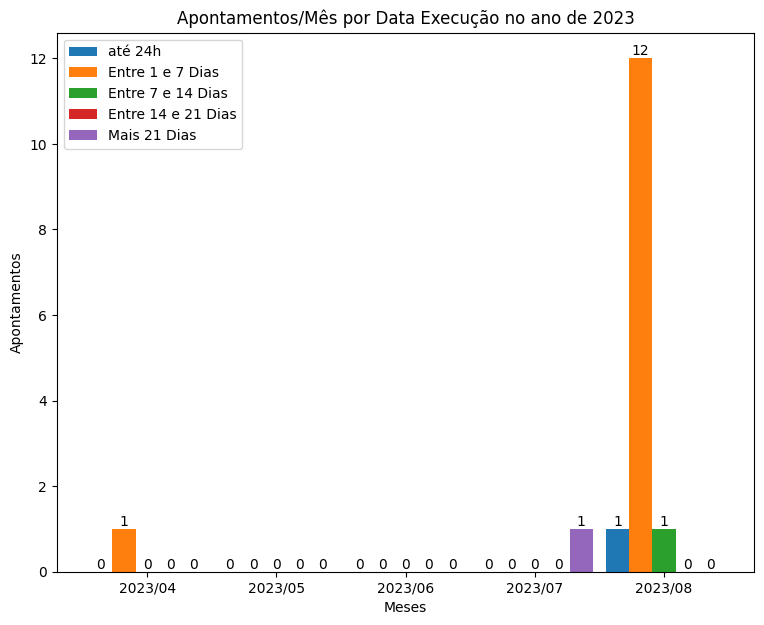

In [36]:
# df2.iloc[:4] pegar o 4 primeiros meses somente
ax1 = df2.plot(y=list(df2.columns),figsize=(9,7), kind='bar', stacked=False,title='Apontamentos/Mês por Data Execução no ano de 2023',xlabel='Meses',ylabel='Apontamentos',width=0.9)
plt.xticks(rotation = 0)
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge')
plt.savefig(path+'apontamentos.png', dpi=300, bbox_inches='tight')

In [37]:
l_periodo,df2.columns

([1, 13, 1, 0, 1],
 Index(['até 24h', 'Entre 1 e 7 Dias', 'Entre 7 e 14 Dias',
        'Entre 14 e 21 Dias', 'Mais 21 Dias'],
       dtype='object'))

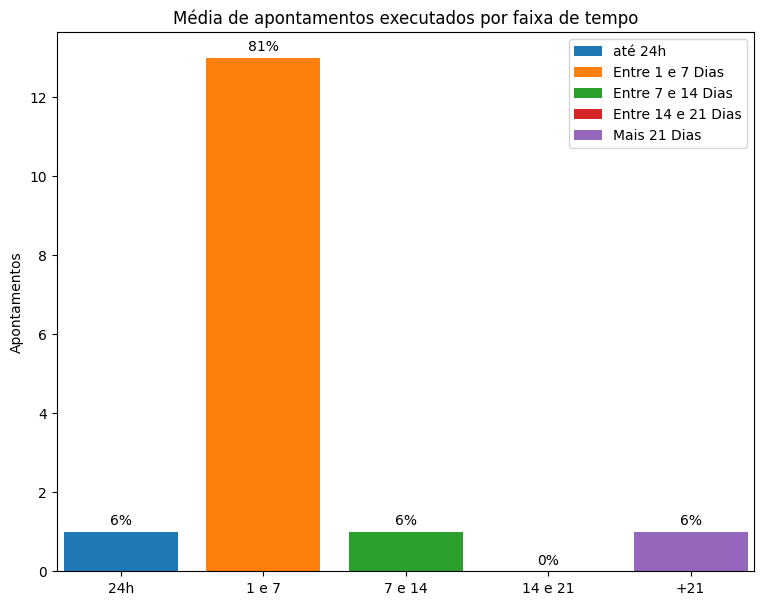

In [38]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(9,7)

bar_labels = ['24h', '1 e 7', '7 e 14', '14 e 21', '+21']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
for i,a in enumerate(l_periodo):
    ax.bar(bar_labels[i], l_periodo[i], label=df2.columns[i])

ax.set_ylabel('Apontamentos')
ax.set_xmargin(0.01)
ax.set_title('Média de apontamentos executados por faixa de tempo')
ax.legend(title='',prop={'size': 10})


# for label in ax.patches:
#     print(label)

for rect, label in zip(ax.patches, l_periodo):
    plt.annotate(format(rect.get_height()/sum(l_periodo), '.0%'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')


plt.savefig(path+'media_apontamentos_faixa.png', dpi=300, bbox_inches='tight')

In [39]:
df_tempo_medio = df.groupby(["Data"]).mean().drop('Tempo para Exec. Horas', axis='columns')

In [40]:
df_tempo_medio

,Tempo para Exec. Dias
Data,
2023/01,0.000000
2023/02,0.285714
2023/03,0.000000
2023/04,0.028169
2023/05,0.000000
2023/06,0.000000
2023/07,0.350467
2023/08,0.360190


In [41]:
#df_tempo_medio.drop('None/', axis = 0, inplace = True)

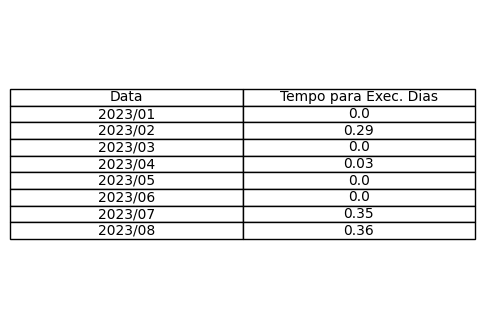

In [42]:
df_tempo_medio_2 = df_tempo_medio.reset_index()
df_tempo_medio_2['Tempo para Exec. Dias'] = round(df_tempo_medio_2['Tempo para Exec. Dias'],2)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=df_tempo_medio_2.values, colLabels=df_tempo_medio_2.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_tempo.png', bbox_inches='tight')

In [43]:
df_tempo_medio["Tempo para Exec. Dias"] = df_tempo_medio["Tempo para Exec. Dias"].round(2)

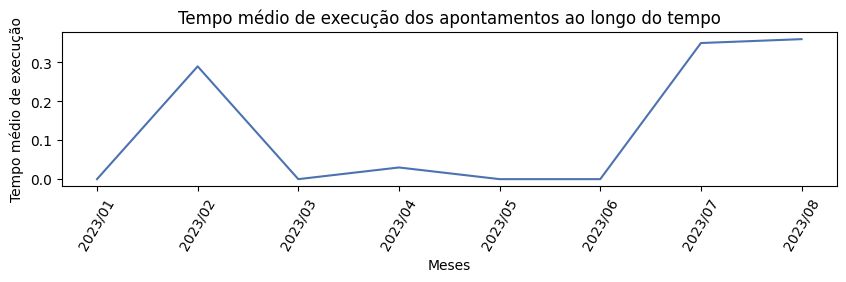

In [44]:
fig, ax = plt.subplots(figsize = ( 10 , 2 ))
sns.lineplot(df_tempo_medio, ax = ax, legend = False, palette = 'deep')
plt.xticks(rotation = 60)
ax.set_xlabel("Meses")
ax.set_ylabel("Tempo médio de execução")
ax.set_title("Tempo médio de execução dos apontamentos ao longo do tempo")
sns.set_style('whitegrid')
for i in ax1.containers:
    ax1.bar_label(i, label_type='edge')
plt.savefig(path+'tempo_exe_apontamentos.png', dpi=300, bbox_inches='tight')

In [45]:
qtd = {}
for i in df_tempo_medio.index:
    a = i.split('/')[0] 
    m = i.split('/')[1]
    reportings = Reporting.objects.filter(
        created_at__year = a, 
        created_at__month = m, 
        company__name__in = company
    ).exclude(
        occurrence_type__occurrence_kind='2'
    ).exclude(
        created_by__username='rlcs'
    ).exclude(
        created_by__username='cartcs'
    ).only(
        'form_data', 
        'occurrence_type'
    ).select_related('occurrence_type')
    if not qtd.get(i):
        print(reportings.count())
        qtd[i] = reportings.count()

17
75
67
66
111
164
210
388


In [46]:
qtd

{'2023/01': 17,
 '2023/02': 75,
 '2023/03': 67,
 '2023/04': 66,
 '2023/05': 111,
 '2023/06': 164,
 '2023/07': 210,
 '2023/08': 388}

In [47]:
df_qtd = pd.DataFrame(data = qtd.values(), index = qtd.keys(), columns = ['Qtd. apontamentos'])

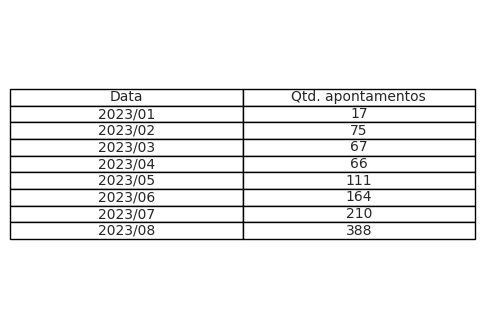

In [48]:
df_qtd_2 = df_qtd.reset_index()
df_qtd_2.rename(columns={'index': 'Data'}, inplace = True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=df_qtd_2.values, colLabels=df_qtd_2.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_qtd.png', bbox_inches='tight')

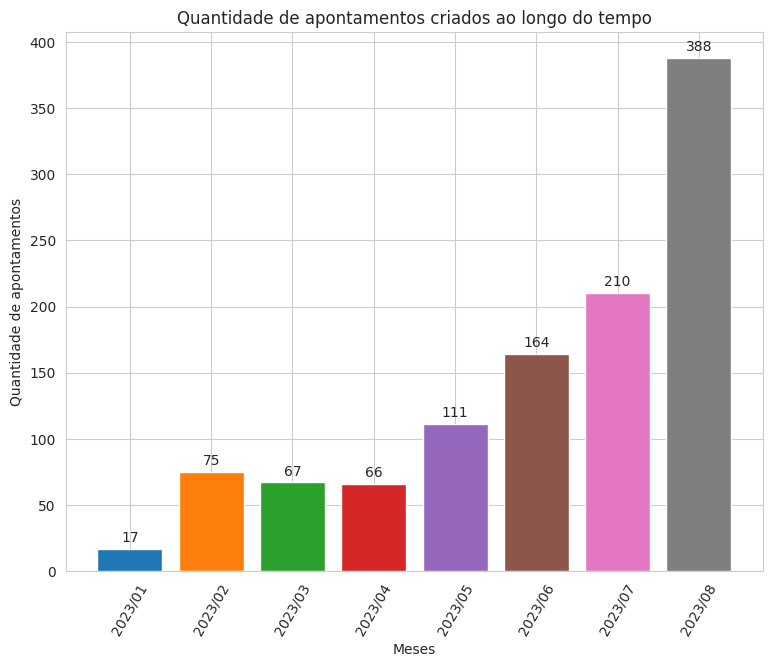

In [49]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Quantidade de apontamentos criados ao longo do tempo')
ax.set_ylabel('Quantidade de apontamentos')
ax.set_xlabel('Meses')
#bar_labels= months_number
plt.xticks(rotation = 60)
for i,a in enumerate(df_qtd["Qtd. apontamentos"]):
    ax.bar(df_qtd.index[i], df_qtd["Qtd. apontamentos"][i])


for rect, label in zip(ax.patches, df_qtd.index):
    plt.annotate(format(rect.get_height(), '.0f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.savefig(path+'qtd_apontamentos.png', dpi=300, bbox_inches='tight')

In [50]:
ano = set()
mes = []
for i in df_qtd.index:
    mes.append(i.split('/')[1])
    ano.add(i.split('/')[0])

In [51]:
ano

{'2023'}

In [52]:
mes

['01', '02', '03', '04', '05', '06', '07', '08']

In [53]:
def quantitativos_v2(df,company):
    sem_qtt =[]
    for i in df_qtd.index:
        a = i.split('/')[0] 
        m = i.split('/')[1]
        com_qtt = 0
        apontamentos_totais = 0
        for occ in OccurrenceType.objects.filter(
            company = road_company,
        ).exclude(
            occurrence_kind='2'
        ):
            autofill_keys = []
            autofill_keys = [
                field["apiName"] for field in occ.form_fields["fields"] if "autofill" in field.keys()
            ]
            size_occ=len(autofill_keys)            
            reportings = Reporting.objects.filter(
                occurrence_type = occ,
                created_at__year = a,
                created_at__month = m, 
                company__name__in = company
            ).exclude(
                occurrence_type__occurrence_kind='2'
            ).exclude(
                created_by__username='rlcs'
            ).exclude(
                created_by__username='cartcs'
            ).only(
                'form_data',
                'occurrence_type'
            ).prefetch_related('occurrence_type')
            reportings_keys=[len(a.keys()) for a in list(reportings.values_list('form_data', flat=True))]            
            com_qtt += len([a for a in reportings_keys if a > size_occ])
            apontamentos_totais += reportings.count()
        sem_qtt.append((apontamentos_totais - com_qtt)/apontamentos_totais if apontamentos_totais != 0 else 0)
    return sem_qtt

In [54]:
qtt = quantitativos_v2(df_qtd,company)

In [55]:
qtt

[1.0,
 0.9733333333333334,
 1.0,
 1.0,
 0.9009009009009009,
 1.0,
 0.8666666666666667,
 0.42010309278350516]

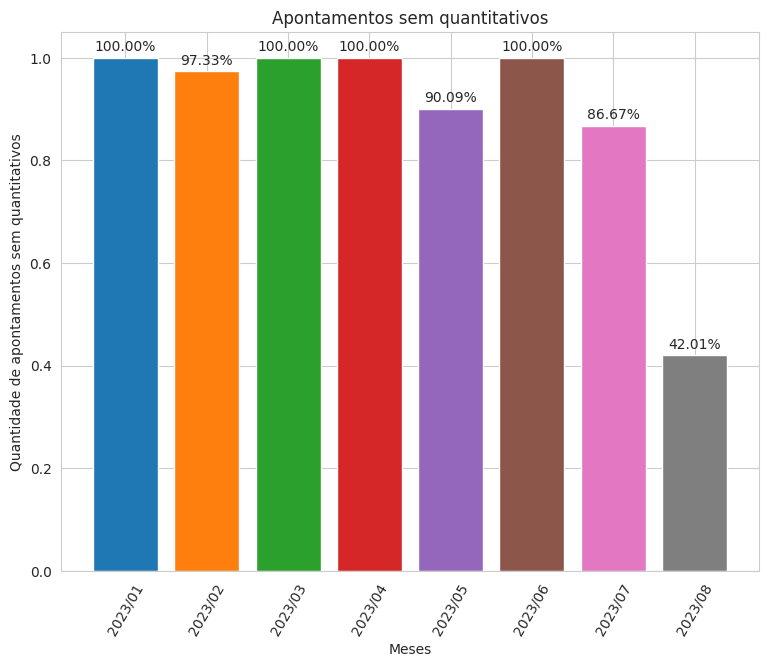

In [56]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Apontamentos sem quantitativos')
ax.set_ylabel('Quantidade de apontamentos sem quantitativos')
ax.set_xlabel('Meses')
#bar_labels= months_number
plt.xticks(rotation = 60)
for i,a in enumerate(qtt):
    ax.bar(df_qtd.index[i], qtt[i])


for rect, label in zip(ax.patches, df_qtd.index):
    plt.annotate(format(rect.get_height(), '.2%'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.savefig(path+'sem_qtt.png', dpi=300, bbox_inches='tight')

In [57]:
def dias_de_uso_v2(df, company):
    
    qtd_dias = []
    dias = {1: 31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31,9: 30, 10:31, 11:30, 12:31}
    
    for index, i in enumerate(df_qtd.index):
        a = i.split('/')[0] 
        m = i.split('/')[1]
        q = []
        for n in range(1, dias[int(m)]):
            q.append(
                Reporting.objects.filter(
                    company__name__in = company, 
                    created_at__year=a, 
                    created_at__month = m,
                    created_at__day=n
                ).exclude(
                    occurrence_type__occurrence_kind='2'
                ).exclude(
                    created_by__username='rlcs'
                ).exclude(
                    created_by__username='neoviacs'
                ).exclude(
                    created_by__username='arteriscs'
                ).only('uuid').count()
            )
        qtd_dias.append(q)
    
    quantidade = []
    porcen_dias= []
    for qtd in qtd_dias:
        quantidade.append(len([x for x in qtd if x != 0]))

    for index, i in enumerate(df_qtd.index):
        m = i.split('/')[1]
        b = quantidade[index]/dias[int(m)]
        porcen_dias.append(round(b*100,2))
    return porcen_dias

In [58]:
d = dias_de_uso_v2(df_qtd,company)

In [59]:
dias_de_uso = pd.DataFrame(zip(df_qtd.index, d), columns = ['Data', 'Porcentagem uso do sistema' ])

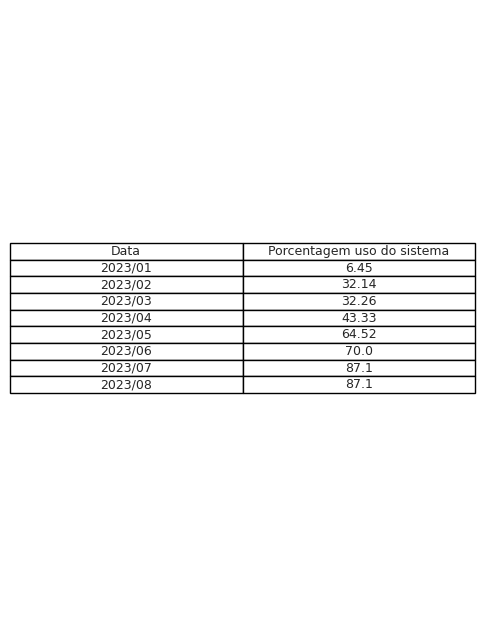

In [60]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.axis('off')
ax.table(cellText=dias_de_uso.values, colLabels=dias_de_uso.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_uso.png', bbox_inches='tight')

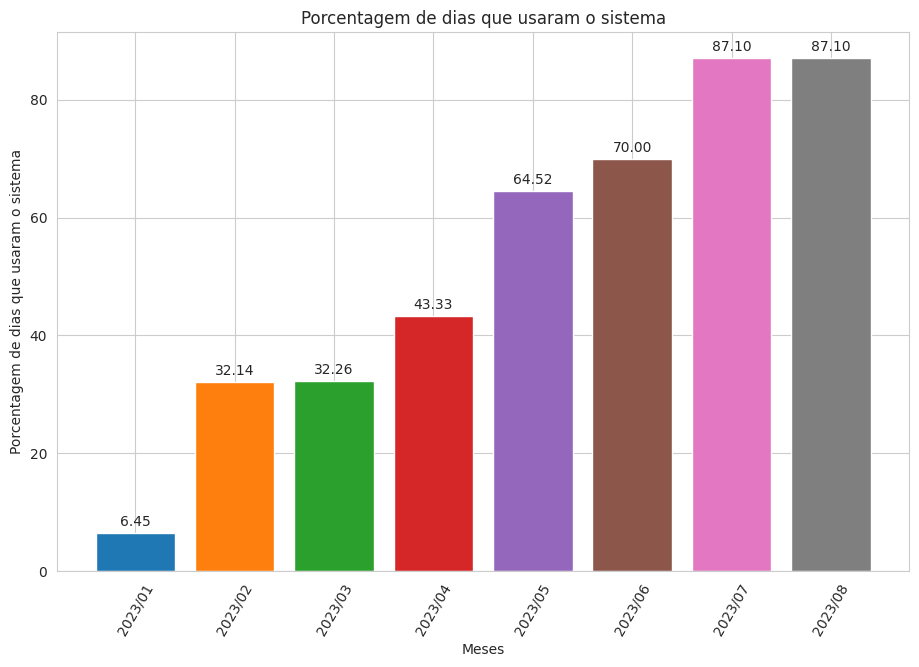

In [61]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(11,7)
ax.set_title('Porcentagem de dias que usaram o sistema')
ax.set_ylabel('Porcentagem de dias que usaram o sistema')
ax.set_xlabel('Meses')
plt.xticks(rotation = 60)

for i,a in enumerate(d):
    ax.bar(df_qtd.index[i], d[i])

for rect, label in zip(ax.patches, df_qtd.index):
    plt.annotate(format(rect.get_height(), '.2f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig(path+'uso_sistema.png', dpi=300, bbox_inches='tight')

In [62]:
def equipes_ativas_v2(df, company):
    team_name = list(
        Firm.objects.filter(
            company_id = road_company.uuid
        ).values_list(
            'name', flat=True
        )
    )
    porcen = []
    for index, i in enumerate(df_qtd.index):
        a = i.split('/')[0] 
        m = i.split('/')[1]
    
        equipes=[]
        for team in team_name:
            equipes.append(
                Reporting.objects.filter(
                    company__name__in = company, 
                    created_at__year=a, 
                    created_at__month= m,
                    firm__name = team
                ).exclude(
                    occurrence_type__occurrence_kind='2'
                ).exclude(
                    created_by__username='rlcs'
                ).exclude(
                    created_by__username='neoviacs'
                ).exclude(
                    created_by__username='arteriscs'
                ).only('uuid').count()
            )

        
        firm_moves=[]
        objects=['Reporting', 'Job']
        for firm in team_name:
            num_moves = 0
            for item in objects:
                num_moves+=eval(item).history.filter(
                    history_date__year=a, 
                    history_date__month=m, 
                    company__name__in= company,
                    firm__name=firm
                ).only('uuid').count()
            firm_moves.append((num_moves, firm))

        firm_moves.sort(key=lambda tup: tup[0], reverse=True)
        active_firms=len([firm for firm in firm_moves if firm[0]>0])
        porcen.append(round(active_firms*100/len(firm_moves),2) if len(firm_moves) != 0 else 0)
    
    return porcen

In [63]:
e = equipes_ativas_v2(df_qtd, company)

In [64]:
dias_de_uso = pd.DataFrame(zip(df_qtd.index, e), columns = ['Data', 'Porcentagem de equipes ativas' ])

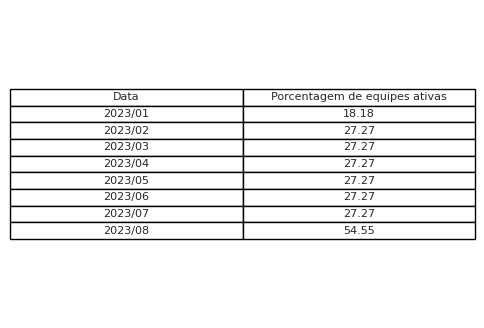

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=dias_de_uso.values, colLabels=dias_de_uso.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_equipes.png', bbox_inches='tight')

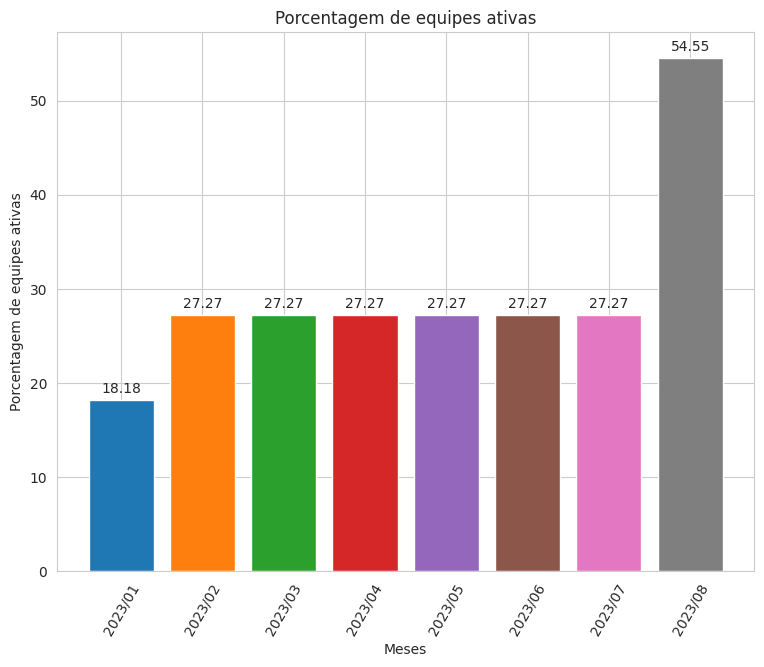

In [66]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Porcentagem de equipes ativas')
ax.set_ylabel('Porcentagem de equipes ativas')
ax.set_xlabel('Meses')
plt.xticks(rotation = 60)

for i,a in enumerate(d):
    ax.bar(df_qtd.index[i], e[i])

for rect, label in zip(ax.patches, df_qtd.index):
    plt.annotate(format(rect.get_height(), '.2f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig(path+'equipes_ativas.png', dpi=300, bbox_inches='tight')

In [67]:
def variacao(months):
    taxa_variacao = []
    for i,m in enumerate(months):
        y = months[i]
        b = months
        c = b.index(y) 
        if c == 0:
            taxa_variacao.append(0)
        if y > b[c-1] and c != 0:
            m = round(((y-b[c-1])/y)*100,2)
            taxa_variacao.append(m)
        if y == b[c-1] and c != 0:
            i = y*0
            taxa_variacao.append(i)
        if y < b[c-1] and c!= 0 :
            n = round(((y -b[c-1])/b[c-1])*100, 2)
            taxa_variacao.append(n)
    return taxa_variacao

In [68]:
df_qtd.index

Index(['2023/01', '2023/02', '2023/03', '2023/04', '2023/05', '2023/06',
       '2023/07', '2023/08'],
      dtype='object')

In [69]:
months=[]
for index, i in enumerate(df_qtd.index):
    a = i.split('/')[0] 
    m = i.split('/')[1]
    months.append(Reporting.objects.filter(company__name__in = company, created_at__year=a, created_at__month=m).exclude(occurrence_type__occurrence_kind='2').exclude(created_by__username='rlcs').exclude(created_by__username='neoviacs').exclude(created_by__username='arteriscs').only('uuid').count())

In [70]:
months

[17, 75, 67, 66, 111, 164, 210, 388]

In [71]:
v = variacao(months)[1:]

In [72]:
v

[77.33, -10.67, -1.49, 40.54, 32.32, 21.9, 45.88]

In [73]:
df_qtd['Taxa de variacao'] = variacao(months)

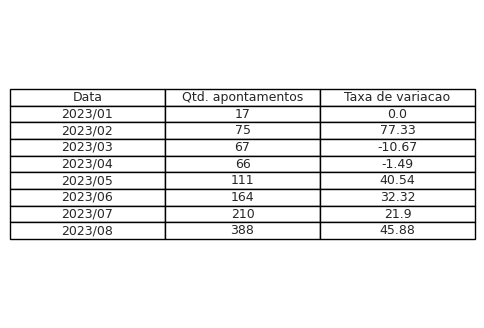

In [74]:
df_taxa = df_qtd.reset_index()
df_taxa.rename(columns={'index': 'Data'}, inplace = True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=df_taxa.values, colLabels=df_taxa.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_variacao.png', bbox_inches='tight')

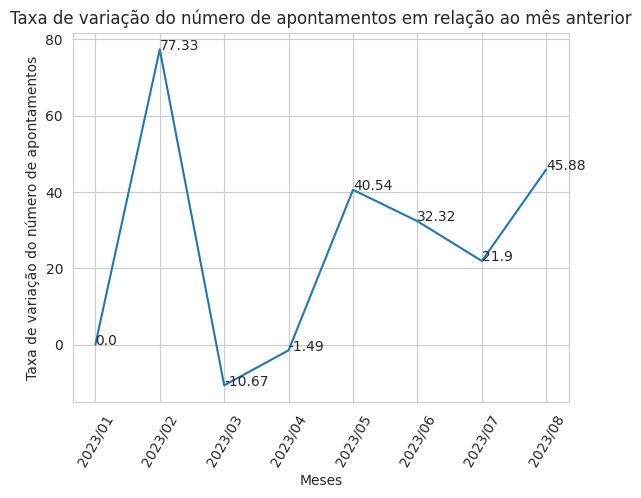

In [75]:
x = df_qtd.index
y = df_qtd['Taxa de variacao']
rotulos = df_qtd['Taxa de variacao']


plt.plot(x, y)

for i in range(len(x)):
    plt.text(x[i], y[i], rotulos[i])

plt.xticks(rotation = 60)
plt.xlabel('Meses')
plt.ylabel('Taxa de variação do número de apontamentos')
plt.title('Taxa de variação do número de apontamentos em relação ao mês anterior')



plt.savefig(path+'variacao_apontamentos.png', dpi=300, bbox_inches='tight')

In [76]:
team_name = list(Firm.objects.filter(company__name__in = company).values_list('name', flat=True))
equipe = {}
for index, i in enumerate(df_qtd.index):
    a = i.split('/')[0] 
    m = i.split('/')[1]
    for team in team_name:
        if not equipe.get(i):
            equipe[i] = {}
        if not equipe[i].get(team):
                equipe[i][team]= Reporting.objects.filter(company__name__in = company, created_at__year=a, created_at__month= m,firm__name = team).exclude(occurrence_type__occurrence_kind='2').exclude(created_by__username='rlcs').exclude(created_by__username='neoviacs').exclude(created_by__username='arteriscs').only('uuid').count()

In [77]:
df_equipes = pd.DataFrame(equipe)

In [78]:
equipe_top3 = []
lista = []
for i in df_equipes.columns:
    a = df_equipes.nlargest(3, i )
    b = a[[i]]
    b['mes'] = i
    c = a[i]
    equipe_top3.append(b)
    lista.append(c)
    

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
equipe_df = pd.concat(equipe_top3)

In [80]:
equipe_df = equipe_df.set_index(['mes',equipe_df.index])

In [81]:
equipe_df.index.set_names(['Data', 'Equipe'], inplace = True)

In [82]:
colunas = equipe_df.columns
equipe_df['Qtd. apontamentos'] = equipe_df.sum(axis = 1)
equipe_df = equipe_df.drop(colunas, axis=1)

In [83]:
equipe_df

Qtd. apontamentos
Data    Equipe                                 
2023/01 Sala Técnica                       14.0
        CONTRATO 631                        3.0
        Manutenção de pontes                0.0
2023/02 CONTRATO 631                       55.0
        CONTRATO 207                       20.0
        Sala Técnica                        0.0
2023/03 CONTRATO 207                       30.0
        CONTRATO 631                       27.0
        Sala Técnica                       10.0
2023/04 Sala Técnica                       36.0
        CONTRATO 207                       26.0
        Suporte                             4.0
2023/05 Sala Técnica                       45.0
        CONTRATO 631                       41.0
        CONTRATO 207                       17.0
2023/06 CONTRATO 631                       58.0
        CONTRATO 139                       43.0
        Sala Técnica                       42.0
2023/07 CONTRATO 139                       86.0
        CONTRATO 207                       57.0
        CONTRATO 631                       46.0
2023/08 CONTRATO 631                      139.0
        CONTRATO 207                      119.0
        CONTRATO 120                       69.0

In [84]:
df

,Encontrado,Executado,Resultado Tempo Exec,Tempo para Exec. Dias,Tempo para Exec. Horas,Natureza,Classe,Data
pavicolet-CON-2023.13598,2023-06-21 19:46:01.722000+00:00,2023-06-21 19:47:17.936000+00:00,0 days 00:01:16.214000,0,0,Conservação,Enrocamento com pedra de mão,2023/06
pavicolet-CON-2023.13877,2023-07-26 16:16:48.880000+00:00,2023-07-26 16:19:19.048000+00:00,0 days 00:02:30.168000,0,0,Conservação,"Desmatamento, destocamento, limpeza de área e ...",2023/07
pavicolet-CON-2023.13631,2023-06-26 09:50:12.051000+00:00,2023-06-26 09:51:25.131000+00:00,0 days 00:01:13.080000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/06
pavicolet-CON-2023.13373,2023-04-18 12:23:17.899000+00:00,2023-04-18 12:25:23.706000+00:00,0 days 00:02:05.807000,0,0,Conservação,Compactação de aterros a 100% do Proctor Normal,2023/04
pavicolet-CON-2023.14051,2023-08-03 18:51:44.091000+00:00,2023-08-03 18:52:36.092000+00:00,0 days 00:00:52.001000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/08
...,...,...,...,...,...,...,...,...
pavicolet-CON-2023.14587,2023-08-25 12:54:27.079000+00:00,2023-08-25 12:56:11.553000+00:00,0 days 00:01:44.474000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/08
pavicolet-CON-2023.14576,2023-08-23 16:16:09.553000+00:00,2023-08-23 16:16:51.475000+00:00,0 days 00:00:41.922000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/08
pavicolet-CON-2023.14568,2023-08-22 11:53:44.968000+00:00,2023-08-22 11:54:35.990000+00:00,0 days 00:00:51.022000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/08
pavicolet-CON-2023.14586,2023-08-24 10:11:36.225000+00:00,2023-08-24 10:11:50.467000+00:00,0 days 00:00:14.242000,0,0,Conservação,Recomposição do revestimento primário com mate...,2023/08


In [85]:
ranking_natureza = df[['Data','Natureza']]

In [86]:
ranking_natureza

,Data,Natureza
pavicolet-CON-2023.13598,2023/06,Conservação
pavicolet-CON-2023.13877,2023/07,Conservação
pavicolet-CON-2023.13631,2023/06,Conservação
pavicolet-CON-2023.13373,2023/04,Conservação
pavicolet-CON-2023.14051,2023/08,Conservação
...,...,...
pavicolet-CON-2023.14587,2023/08,Conservação
pavicolet-CON-2023.14576,2023/08,Conservação
pavicolet-CON-2023.14568,2023/08,Conservação
pavicolet-CON-2023.14586,2023/08,Conservação


In [87]:
frequencia = ranking_natureza.groupby('Data')['Natureza'].value_counts()



In [88]:
freq = pd.DataFrame(frequencia)

In [89]:
freq.rename(columns={'Natureza' : 'Qtd. de apontamentos'}, inplace = True)

In [90]:
freq

Qtd. de apontamentos
Data    Natureza                                                                
2023/01 Conservação                                                           14
        Aquisição asfalto                                                      1
2023/02 Conservação                                                           18
        Mobilização/Desmobilização; Instalação de Cante...                     2
        Manutenção de pontes de madeira                                        1
2023/03 Conservação                                                           38
        Manutenção de pontes de madeira                                        7
2023/04 Conservação                                                           71
2023/05 Conservação                                                           71
        Dispositivos de sinalização                                            1
2023/06 Conservação                                                          156
        Dispositivos de drenagem                                               3
2023/07 Conservação                                                          203
        Dispositivos de sinalização                                            9
        Dispositivos de drenagem                                               2
2023/08 Conservação                                                          205
        Dispositivos de drenagem                                               3
        Controle Tecnológico                                                   1
        Dispositivos de sinalização                                            1
        Inventário                                                             1

In [91]:
maior = freq.groupby('Data')['Qtd. de apontamentos'].idxmax()

In [92]:
maior

Data
2023/01    (2023/01, Conservação)
2023/02    (2023/02, Conservação)
2023/03    (2023/03, Conservação)
2023/04    (2023/04, Conservação)
2023/05    (2023/05, Conservação)
2023/06    (2023/06, Conservação)
2023/07    (2023/07, Conservação)
2023/08    (2023/08, Conservação)
Name: Qtd. de apontamentos, dtype: object

In [93]:
maior_equipe_mes = freq.loc[maior]

In [94]:
maior_equipe_mes.reset_index(inplace = True)

In [95]:
maior_equipe_mes

,Data,Natureza,Qtd. de apontamentos
0,2023/01,Conservação,14
1,2023/02,Conservação,18
2,2023/03,Conservação,38
3,2023/04,Conservação,71
4,2023/05,Conservação,71
5,2023/06,Conservação,156
6,2023/07,Conservação,203
7,2023/08,Conservação,205


In [96]:
maior_equipe_mes['Natureza'] = maior_equipe_mes['Natureza'].str[:6]

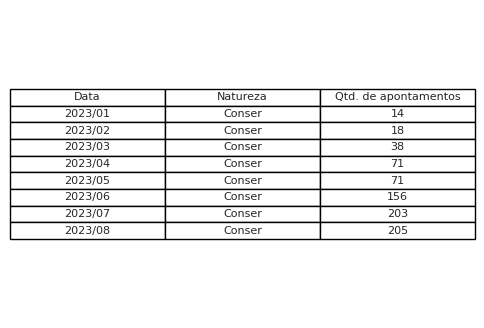

In [97]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=maior_equipe_mes.values, colLabels=maior_equipe_mes.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_natureza.png', bbox_inches='tight')

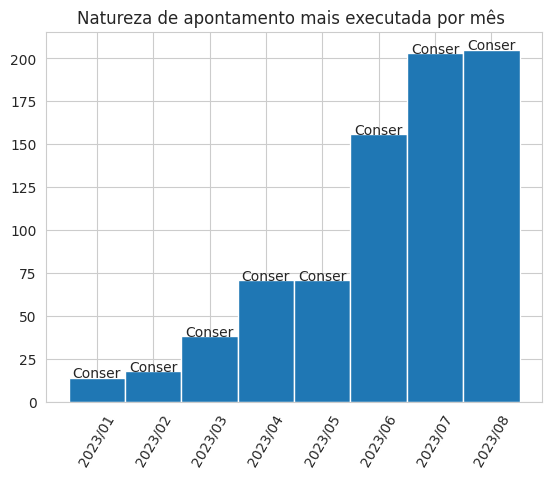

In [98]:
plt.bar(maior_equipe_mes['Data'], maior_equipe_mes['Qtd. de apontamentos'],width=1.0)
legenda = maior_equipe_mes['Natureza'].tolist()
x = maior_equipe_mes['Data']
y = maior_equipe_mes['Qtd. de apontamentos']
plt.title('Natureza de apontamento mais executada por mês ')
plt.xticks(rotation = 60) 


for i, label in enumerate(legenda):
    plt.text(x[i], y[i], label, ha='center')
    

plt.savefig(path+'natureza.png', dpi=300, bbox_inches='tight')

In [99]:
try:    
    natureza = traduzirNaturezaName('Monitoramentos')
except:
    natureza = traduzirNaturezaName1('Monitoramentos')

In [100]:
natureza

''

In [101]:
qtd_registro_monitoramento = Reporting.objects.filter(company__name__in = company, occurrence_type__occurrence_kind = natureza).count()

In [102]:
print('Quantidade de registros de monitoramento:', qtd_registro_monitoramento)

Quantidade de registros de monitoramento: 0


# Programações

In [103]:
jobs = Job.objects.filter(company__name__in = company, start_date__gte = '2023-01-01', start_date__lte = data_relatorios).exclude(created_by__username='rlcs').exclude(created_by__username='neoviacs').exclude(created_by__username='arteriscs')
jobs.count()

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField Job.start_date received a naive datetime (2023-01-01 00:00:00) while time zone support is active.
  RuntimeWarning)
/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField Job.start_date received a naive datetime (2023-08-31 00:00:00) while time zone support is active.
  RuntimeWarning)


14

In [104]:
zero=0
faixa05=0
faixa9=0
faixa10=0
for a in jobs:
    if a.progress == 0:
        zero+=1
    elif a.progress > 0 and a.progress <=0.5:
        faixa05+=1
    elif a.progress > 0.5 and a.progress <=0.99:
        faixa9+=1
    else:
        faixa10+=1
    
        
faixas=[zero,faixa05,faixa9,faixa10]

In [105]:
bar_labels = ['Zeradas','0-50%','50-99%','100%']

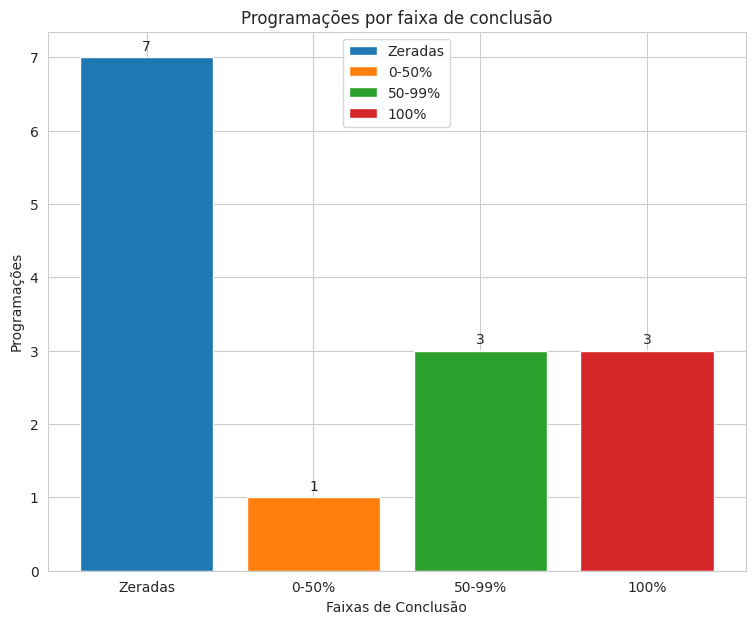

In [106]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Programações por faixa de conclusão')
ax.set_ylabel('Programações')
ax.set_xlabel('Faixas de Conclusão')


for i,a in enumerate(faixas):
    ax.bar(bar_labels[i], faixas[i], label=bar_labels[i])

ax.legend(title='',loc='upper center',prop={'size': 10})
    
for rect, label in zip(ax.patches, faixas):
    plt.annotate(format(rect.get_height(), '.0f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig(path+'prog_faixa_conclusao.png', dpi=300, bbox_inches='tight')

In [107]:
jobs2 = Job.objects.filter(start_date__gte = '2023-01-01', progress__lt=1,company__name__in=company).exclude(created_by__username='rlcs').exclude(created_by__username='neoviacs').exclude(created_by__username='arteriscs')

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField Job.start_date received a naive datetime (2023-01-01 00:00:00) while time zone support is active.
  RuntimeWarning)


In [108]:
jobs2[0].__dict__

{'_state': <django.db.models.base.ModelState at 0x7f45f46dec90>,
 'uuid': UUID('fe6c14a1-2453-4fba-be8f-5c19621342a5'),
 'company_id': UUID('ee7795f4-c04a-4f5c-8918-47c3d8645de7'),
 'number': 'pavicolet-job-2023.17',
 'title': 'PROGRAMAÇÃO MENSAL SR 207 09 2023 COM RECURSOS ALOCADOS rev. 3',
 'description': '',
 'start_date': datetime.datetime(2023, 8, 30, 19, 53, 10, 697000, tzinfo=<UTC>),
 'end_date': datetime.datetime(2023, 8, 31, 19, 53, tzinfo=<UTC>),
 'progress': 0.0,
 'executed_reportings': 0,
 'reporting_count': 25,
 'worker_id': UUID('c634d64b-5da1-4f5c-bc59-ac918da2946c'),
 'firm_id': UUID('4a072268-6ea5-400c-942b-fa80cbd40ab0'),
 'inspection_id': None,
 'parent_inventory_id': None,
 'metadata': {},
 'created_by_id': UUID('5f046393-edf9-49ce-9eff-b5126442a630'),
 'archived': True,
 'last_notification_sent_at': None}

In [109]:
data={}
arquivadas=0
narquivadas,ven0,ven05,ven59=0,0,0,0
for a in jobs2:
    if a.end_date is not None:
        if a.end_date.date() <= date.today():
            arquivadas+=1 if a.archived == True else 0
            narquivadas+=1 if a.archived == False else 0
            ven59+=1 if a.progress > 0.5 else 0
            ven0+=1 if a.progress ==0 else 0
            ven05+=1 if a.progress > 0 and a.progress <= 0.5 else 0
            
            data[a.number]={}
            data[a.number]['data_final'] = a.end_date
            
            data[a.number]['progresso'] = a.progress*100
dfjob=pd.DataFrame(data=data).transpose()
job_vencido=[ven0,ven05,ven59]

In [110]:
dfjob.head()

,data_final,progresso
pavicolet-job-2023.17,2023-08-31 19:53:00+00:00,0.0
pavicolet-job-2023.19,2023-09-01 19:59:00+00:00,0.0
pavicolet-job-2023.18,2023-09-01 19:50:00+00:00,64.0
pavicolet-job-2023.20,2023-09-02 10:57:00+00:00,63.0
pavicolet-job-2023.2,2023-08-31 15:28:00+00:00,0.0


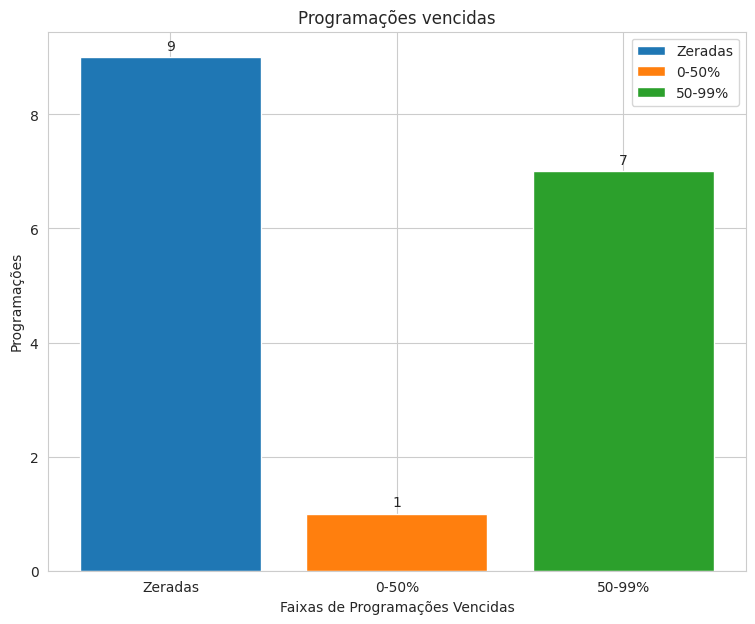

In [111]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Programações vencidas')
ax.set_ylabel('Programações')
ax.set_xlabel('Faixas de Programações Vencidas')
bar_labels=['Zeradas','0-50%','50-99%']

for i,a in enumerate(job_vencido):
    ax.bar(bar_labels[i], job_vencido[i], label=bar_labels[i])

ax.legend(title='',prop={'size': 10})
    
for rect, label in zip(ax.patches, job_vencido):
    plt.annotate(format(rect.get_height(), '.0f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig(path+'prog_vencidas.png', dpi=300, bbox_inches='tight')

# RDO

In [112]:
rdos = MultipleDailyReport.objects.filter(company__name__in = company, created_at__gte= '2023-01-01', created_at__lte = data_relatorios)

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField MultipleDailyReport.created_at received a naive datetime (2023-01-01 00:00:00) while time zone support is active.
  RuntimeWarning)
/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField MultipleDailyReport.created_at received a naive datetime (2023-08-31 00:00:00) while time zone support is active.
  RuntimeWarning)


In [113]:
rdos.count()

28

In [114]:
rdo_dict = {}
for i in rdos:
    #print(i.created_at.date())
    rdo_dict[i.number] = {'Equipe': i.firm.name, 'Criado em': i.created_at.date()}

In [115]:
df_rdo = pd.DataFrame(rdo_dict.values(), index = rdo_dict.keys())

In [116]:
df_rdo

,Equipe,Criado em
pavicolet-RDO-2023.00047,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00046,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00045,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00044,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00043,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00042,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00041,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00040,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00039,CONTRATO 631,2023-08-28
pavicolet-RDO-2023.00038,CONTRATO 631,2023-08-28


In [117]:
df_rdo_equipes = df_rdo.groupby('Equipe').count()

In [118]:
df_rdo['Data'] = df_rdo['Criado em'].apply(lambda x: str(x)[:4]) + '/'+df_rdo['Criado em'].apply(lambda x: str(x)[5:7])

In [119]:
df_rdo_data = df_rdo.groupby('Data').count()

In [120]:
months_rdo=[]
for index, i in enumerate(df_rdo_data.index):
    a = i.split('/')[0] 
    m = i.split('/')[1]
    months_rdo.append(MultipleDailyReport.objects.filter(company__name__in = company, created_at__year=a, created_at__month=m).count())

In [121]:
df_rdo_data['Taxa de variacao'] = variacao(months_rdo)

In [122]:
df_rdo_data

,Equipe,Criado em,Taxa de variacao
Data,,,
2023/08,28,28,0


In [123]:
df_variacao = df_rdo_data.drop('Equipe', axis=1)

In [124]:
df_variacao.rename(columns = {'Criado em': 'Qtd. de apontamentos'}, inplace = True)

In [125]:
df_variacao

,Qtd. de apontamentos,Taxa de variacao
Data,,
2023/08,28,0


In [126]:
df_rdo_equipes.rename(columns={'Criado em' : 'Qtd. de apontamentos'}, inplace = True)

In [127]:
df_rdo_equipes

,Qtd. de apontamentos
Equipe,
CONTRATO 207,2
CONTRATO 631,26


In [128]:
maior_equipe_rdo = df_rdo_equipes.nlargest(10, 'Qtd. de apontamentos')

In [129]:
maior_equipe_rdo

,Qtd. de apontamentos
Equipe,
CONTRATO 631,26
CONTRATO 207,2


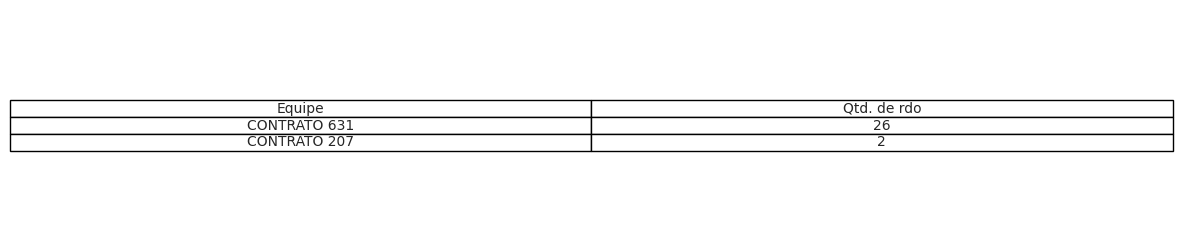

In [130]:
df_rdo = maior_equipe_rdo.reset_index()
df_rdo.rename(columns={'Qtd. de apontamentos': 'Qtd. de rdo'}, inplace = True)
fig, ax = plt.subplots(figsize=(15, 3))
ax.axis('off')
ax.table(cellText=df_rdo.values, colLabels=df_rdo.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_rdo_equipe.png', bbox_inches='tight')

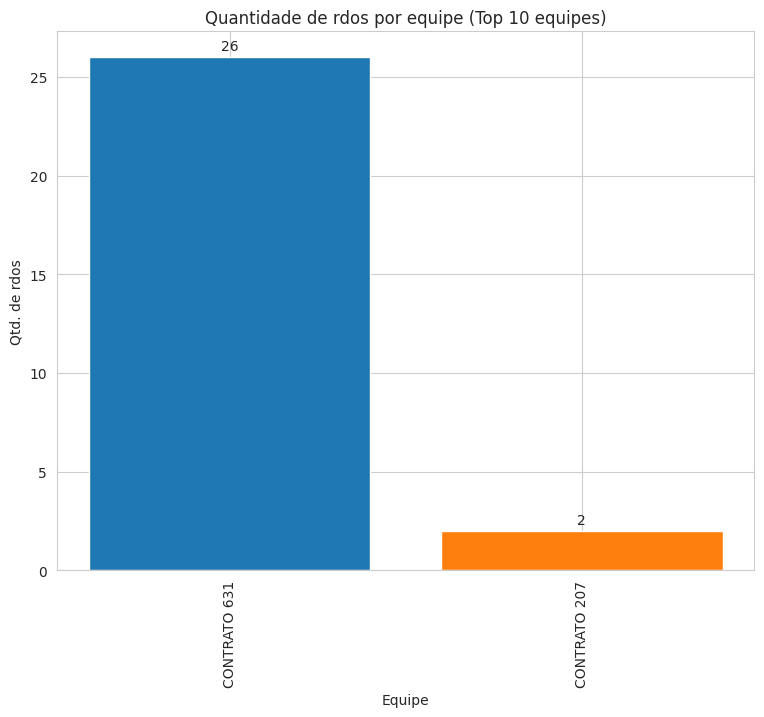

In [131]:
x = list(maior_equipe_rdo.index)
y = maior_equipe_rdo['Qtd. de apontamentos']
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Quantidade de rdos por equipe (Top 10 equipes)')
ax.set_ylabel('Qtd. de rdos')
ax.set_xlabel('Equipe')

plt.xticks(rotation = 90)
for i,a in enumerate(y):
    ax.bar(x[i], y[i])


for rect, label in zip(ax.patches, x):
    plt.annotate(format(rect.get_height()),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')


plt.savefig(path+'equipe_rdos.png', dpi=300, bbox_inches='tight')

In [132]:
variacao(months_rdo)

[0]

In [133]:
df_variacao

,Qtd. de apontamentos,Taxa de variacao
Data,,
2023/08,28,0


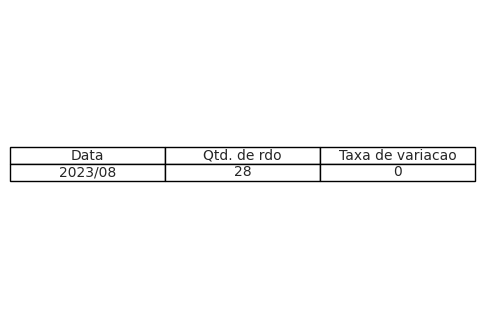

In [134]:
df_rdo_variacao = df_variacao.reset_index()
df_rdo_variacao.rename(columns={'Qtd. de apontamentos': 'Qtd. de rdo'}, inplace = True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
ax.table(cellText=df_rdo_variacao.values, colLabels=df_rdo_variacao.columns, cellLoc='center', loc='center')

# Salvar como imagem
plt.savefig(path+'data_rdo_variacao.png', bbox_inches='tight')

# Contratos

In [135]:
contracts = Contract.objects.filter(subcompany__company__name__in = company, created_at = data_relatorios)

/home/luan/.cache/pypoetry/virtualenvs/apps-ZFymp6kh-py3.7/lib/python3.7/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField Contract.created_at received a naive datetime (2023-08-31 00:00:00) while time zone support is active.
  RuntimeWarning)


In [136]:
print('Número de contratos cadastrados:',contracts.count())


Número de contratos cadastrados: 0


In [137]:
contratos = {}
for i in contracts:
    adm = i.administration_services.count()
    perfor = i.performance_services.count()
    preco_uni = i.unit_price_services.count()
    contratos[i.uuid] =  {'admin' : adm, 'performance': perfor, 'preco_unitario' : preco_uni}

In [138]:
contratos

{}

In [139]:
df_contratos = pd.DataFrame(contratos)
df_contratos = df_contratos.T

In [140]:
df_contratos

""


In [141]:
total = len(df_contratos.index)
perform_count = df_contratos.where(df_contratos.performance != 0).count()[0]
admin_count = df_contratos.where(df_contratos.admin != 0).count()[0]
preco_unit_count = df_contratos.where(df_contratos.preco_unitario != 0).count()[0]

AttributeError: 'DataFrame' object has no attribute 'performance'

In [ ]:
lista_tipo = [admin_count/total,perform_count/total, preco_unit_count/total]

In [ ]:
x = list(df_contratos.columns)
y = lista_tipo
fig, ax = plt.subplots()

ax.figure.set_size_inches(9,7)
ax.set_title('Porcentagem do tipo de cadastro')
ax.set_ylabel('Porcentagem')
ax.set_xlabel('Tipo')
#bar_labels= months_number

for i,a in enumerate(y):
    ax.bar(x[i], y[i])


for rect, label in zip(ax.patches, x):
    plt.annotate(format(rect.get_height(), '.2%'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')


plt.savefig(path+'contratos.png', dpi=300, bbox_inches='tight')

In [16]:
import plotly.graph_objects as go
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import plotly.io as pio
from io import BytesIO
import tempfile
from PyPDF2 import PdfReader, PdfWriter

In [17]:
# Create a PDF file
pdf_filename = "output.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)

# Add text to the PDF
c.drawString(100, 750, "Hello, this is a PDF with a Plotly graph appended to it!")

# Generate a sample Plotly graph
fig = go.Figure(data=go.Scatter(x=[1, 2, 3, 4], y=[10, 20, 25, 30]))
fig.update_layout(title='Sample Plotly Graph', xaxis_title='X-axis', yaxis_title='Y-axis')

# Convert the Plotly graph to a static image
image_bytes = pio.to_image(fig, format='png')

# Save the image data to a temporary file
temp_image_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
temp_image_file.write(image_bytes)
temp_image_file.close()

# Append the graph to the PDF
c.drawImage(temp_image_file.name, 100, 500, width=400, height=300)


##
# Generate a sample Plotly graph
fig2 = go.Figure(data=go.Scatter(x=[100, 200, 300, 400], y=[100, 200, 250, 300]))
fig2.update_layout(title='Second Sample Plotly Graph', xaxis_title='X-axis', yaxis_title='Y-axis')

# Convert the Plotly graph to a static image
image_bytes2 = pio.to_image(fig2, format='png')

# Save the image data to a temporary file
temp_image_file2 = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
temp_image_file2.write(image_bytes2)
temp_image_file2.close()

# Create a new PDF document for the graph
c2 = canvas.Canvas(temp_image_file2.name, pagesize=letter)
c2.drawImage(temp_image_file2.name, 100, 1000, width=400, height=300)
##
# Save the PDF file
c.save()

print(f"PDF file '{pdf_filename}' generated successfully with the Plotly graph appended.")


PDF file 'output.pdf' generated successfully with the Plotly graph appended.


In [14]:
# Open an existing PDF file
existing_pdf = "output.pdf"
output_pdf = "output_with_graph.pdf"

# Create a new PDF file with the existing content
output = PdfWriter()
input_pdf = PdfReader(open(existing_pdf, "rb"))
output.add_page(input_pdf.pages[0])

# Generate a sample Plotly graph
fig = go.Figure(data=go.Scatter(x=[100, 200, 300, 400], y=[100, 200, 250, 300]))
fig.update_layout(title='Second Sample Plotly Graph', xaxis_title='X-axis', yaxis_title='Y-axis')

# Convert the Plotly graph to a static image
image_bytes = pio.to_image(fig, format='png')

# Save the image data to a temporary file
temp_image_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
temp_image_file.write(image_bytes)
temp_image_file.close()

# Create a new PDF document for the graph
c = canvas.Canvas(temp_image_file.name, pagesize=letter)
c.drawImage(temp_image_file.name, 100, 1000, width=400, height=300)
c.save()

# Merge the existing PDF with the new content
with open(output_pdf, "wb") as output_stream:
    output.write(output_stream)

print(f"PDF file '{output_pdf}' generated successfully with the Plotly graph appended.")

PDF file 'output_with_graph.pdf' generated successfully with the Plotly graph appended.


In [15]:
fig

In [29]:
from PyPDF2 import PdfWriter
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import plotly.graph_objects as go
import plotly.io as pio
import tempfile
from PyPDF2 import PageObject

# Create a new PDF file
output_pdf = "output_with_graphs.pdf"
output = PdfWriter()

# Generate multiple sample Plotly graphs
graphs = [
    go.Figure(data=go.Scatter(x=[1, 2, 3, 4], y=[10, 20, 25, 30])),
    go.Figure(data=go.Bar(x=['A', 'B', 'C'], y=[10, 20, 30])),
    go.Figure(data=go.Pie(labels=['A', 'B', 'C'], values=[30, 40, 30]))
]

# Convert each Plotly graph to a static image and save to PDF
for idx, fig in enumerate(graphs):
    image_bytes = pio.to_image(fig, format='png')

    temp_image_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_image_file.write(image_bytes)
    temp_image_file.close()

    c = canvas.Canvas(temp_image_file.name, pagesize=letter)
    c.drawImage(temp_image_file.name, 100, 500, width=400, height=300)
    c.save()

    page = PageObject.create_blank_page(width=595, height=842)
    page.insert_page(page)
    output.add_page(page)

# Save the multi-page PDF with graphs
with open(output_pdf, "wb") as output_stream:
    output.write(output_stream)

print(f"PDF file '{output_pdf}' generated successfully with multiple graphs.")

AttributeError: type object 'PageObject' has no attribute 'createFormXObject'

In [19]:
c

In [11]:
now=OccurrenceType.objects.get(name='Luan Classe Teste 1')
nowf=now.form_fields['fields']
last=now.history.all().order_by('-history_date')[1].form_fields['fields']

In [12]:
def comparar_lista_de_json(lista1, lista2):
    diff_list = []

    for i in range(min(len(lista1), len(lista2))):
        json1 = lista1[i]
        json2 = lista2[i]

        for key in json1:
            if key in json2:
                if json1[key] != json2[key]:
                    diff_list.append((i, key, json1[key], json2[key]))
            else:
                diff_list.append((i, key, json1[key], None))

        for key in json2:
            if key not in json1:
                diff_list.append((i, key, None, json2[key]))

    return diff_list

In [13]:
comparar_lista_de_json(nowf, last)

[(0, 'displayName', 'Código de Edital1', 'Código de Edital')]

In [15]:
from jsondiff import diff
diff(nowf, last, syntax='symmetric')

{0: {'displayName': ['Código de Edital1', 'Código de Edital']}}